In [44]:
import numpy as np
from scipy.stats import truncnorm, norm, binom, t
import matplotlib.pyplot as plt
import random
import math

In [2]:
cutoff = 0.95 # The European norm for the required accuracy of the machine

In [3]:
class Wafer:
    pass

In [4]:
class SolarCell:
    def __init__(self, working):
        self.working = working

In [5]:
class Machine:
    runtime = 0  #In Minutes
    costs = 0
    
    def __init__(self, p):  #Constructor
        """Make machine with probability p of turning a wafer into a working cell."""
        self.p = p
    
    def deposit(self, wafer):
        """Deposit a Wafer, returns a SolarCell"""
        self.runtime += 9    #9 minutes per deposition per wafer
        self.costs += 2 + 87/35  #It costs €2 to do a deposition. Wafers have a base cost of €87, but can be re-used 35 times
        working = random.random() < self.p 
        
        return SolarCell(working)
    
    def diagnosis(self, cell):
        """Diagnose a SolarCell, returns whether the cell works"""
        self.runtime += 2 if cell.working else 3  # Diagnosis costs 2 minutes if the created cell works, 3 minutes otherwise
        return cell.working
    
    def test_basic(self, n):
        """Test the machine n times and return the ratio of working cells"""
        wafers = n * [Wafer()] # Create list of n Wafer() objects
        cells = list(map(self.deposit, wafers)) # Deposit all wafers
        working_cells = list(filter(self.diagnosis, cells)) # Make list of working cells
        return len(working_cells)/len(cells) # Determine ratio of the amount of working cells and total cells 
    
    def get_stats(self):
        """Pretty print the status of machine."""
        days = self.runtime // (24 * 60)
        hours = (self.runtime % (24 * 60)) // 60
        minutes = (self.runtime % (24 * 60)) % 60
        rcosts = round(self.costs, 2)
        
        print("Actual accuracy of machine:", self.p)
        print("It takes", days, "day(s),", hours, "hour(s) and", minutes, "minute(s) to test.")
        print("The costs associated with this test method is €" + str(rcosts))
        
    def reset(self):
        """Reset the machine."""
        self.runtime = 0
        self.costs = 0
        
    def plot_pmf(self, n):
        """Plot the probability of each estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.pmf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.pmf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("probability")
        plt.show()
        
    def plot_cdf(self, n):
        """Plot cdf of estimation of p resulting from n tests."""
        fig, ax = plt.subplots(1, 1)
        x = np.arange(binom.ppf(0.001, n, self.p), n+1)
        ax.plot(x/n, binom.cdf(x, n, self.p), 'bo', ms=8, label='binom pmf')
        ax.vlines(x/n, 0, binom.cdf(x, n, self.p), colors='b', lw=5, alpha=0.5)
        ax.axvline(x = self.p, color='g')
        ax.set_xlabel("estimated p")
        ax.set_ylabel("cumulative density function")
        plt.show()

    # Testing with variable number of tests
    def test_advanced(self, certainty, max_tests):
        """ Test the machine until it is certain whether the machine works or we reached the maximum number of tests.
        Certainty is defined by the given certainty, which is a probability (so between 0 and 1).
        Maximum number of tests is given by max_tests.
        """
        successes = 0
        p_ = 1
        start = 5
        
        for n in range(1, start):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
        
        for n in range(start + 1, max_tests + 1):
            if self.diagnosis(self.deposit(Wafer())):
                successes += 1
            p_ = successes / n
            
            (left, right) = self.calculate_interval_(certainty, n, p_)
            print("Left: " + str(left))
            print("Right: " + str(right))
            
            if (left > cutoff and right > cutoff):
                return (p_, n)
            
            if (left < cutoff and right < cutoff):
                return (p_, n)
            
        return (p_, n)
            
    def calculate_interval(self, certainty, n, p_):
        """Returns the interval such that it is certain with the given certainty that after n tests
        the actual probability of the machine lies in this interval"""
        error = (1 - certainty)/2
        
        # We want to calculate an interval such that P(real p in interval) = certainty after n tests, given p_
        # Number of successes S is binomially distributed with P(S=s) = (n s) * (p ^ s) * ((1-p) ^ (n - s))
        # Hence the random variable p_ has p_ ~ 1/n * S
        # Beneath we calculate (left, right) such that P(p_ in (left,right)) = certainty

        left = binom.ppf(error, n, self.p)
        # binom.ppf returns the x for which F(x) = P(X <= x) = error
        # So for example 95% certainty, it returns the amount of successes s such that P(S <= s) = 0.05
        
        right = binom.ppf(1 - error, n, self.p)
        # And here P(S <= s) = 0.95
        
        # So now 95% of the possible amounts of successes lie between (left, right)
        
        # Express this in p_ by adjusting to the ratios
        left = left/n
        right = right/n
        
        # Now 95% of p_ lie in (left, right) => VOLGENS MIJ IS DIT NIET WAT WE WILDEN BEREKENEN
        # Klopt, en we gebruiken ook self.p, wat niet beschikbaar is voor de testers in het echt
        return (left, right)
    
    def calculate_interval_(self, certainty, n, p_):
        """Maybe correct version of calculate_interval"""
        error = (1 - certainty) / 2
        
        # Bounds expressed in successes
        leftS = binom.ppf(error, n, p_)
        rightS = binom.ppf(1 - error, n, p_)
        
        # Express in p_
        return (leftS / n, rightS / n)
    
    def certainty_interval(self, certainty, n):
        """Returns certainty interval around p, s.t. with the given certainty p_ lies in it."""
        (left_S, right_S) = binom.interval(certainty, n, self.p)
        
        # This uses self.p! Which we don't know!
        
        return (left_S / n, right_S / n)
    
    #def certainty_80_interval(n, a, sigma):
    #    """Returns certainty interval of 95%, given n tests, with number of tests n,
    #       average a, standard deviation sigma"""
    #    # Degrees of freedom = n - 1
    #    # Confidence interval is two-sided, so we want 80% chance that p lies in (left, right)
    #    # Or said differently, 90% chance that p lies in (left, infinity) and 90% chance that p lies in (-infinity, right)
    #    t_value = t.ppf(0.9, n - 1) # https://stackoverflow.com/questions/19339305/python-function-to-get-the-t-statistic
    #    print("The t-value is: " + str(t_value))
    #    left = a - t_value * sigma / (math.sqrt(n))
    #    right = a + t_value * sigma / (math.sqrt(n))
    #    return (left, right)
    # TIJDVERSPILLING
    
    def wilson_score_interval_95(p_, n):
        # From https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
        z = 1.96 # for 95% confidence
        left =  (p_ + z^2/(2*n))/(1+z^2/n) + z/(1+z^2/n) * math.sqrt((p_*(1-p_))/n + z^2/(4*n^2))
        right = (p_ + z^2/(2*n))/(1+z^2/n) - z/(1+z^2/n) * math.sqrt((p_*(1-p_))/n + z^2/(4*n^2))
        return (left, right)
        
    def procedure_basic(self, n):
        # This basic test makes n wafers and returns the ratio (=p_) of working wafers
        return self.test_basic(n) >= cutoff
    
    def procedure_trivial(self):
        # This testing procedure basically doesn't test, but accepts all machines
        # Used for cost computation purposes
        return True


In [67]:
def makeMachine(mu, sigma):
    """Factory that makes a machine with accuracies normally distributed."""
    p = truncnorm(-mu / sigma, (1 - mu) / sigma, loc=mu, scale=sigma).rvs(1)[0]
    return Machine(p)

In [27]:
# m = makeMachine(0.98, 0.02)
m = Machine(0.963)

In [28]:
p_ = m.test_basic(100)
print("Projected accuracy of machine:", p_)
m.get_stats()
m.reset()

Projected accuracy of machine: 0.98
Actual accuracy of machine: 0.963
It takes 0 day(s), 18 hour(s) and 22 minute(s) to test.
The costs associated with this test method is €448.57


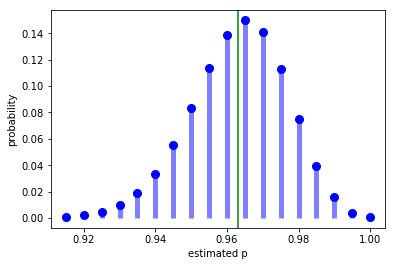

In [29]:
m.plot_pmf(200)

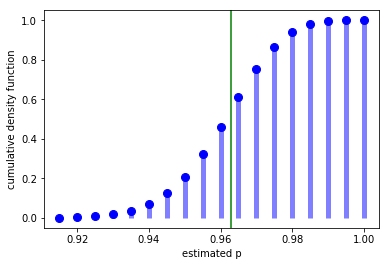

In [30]:
m.plot_cdf(200)

In [31]:
def neighbourhood(m, epsilon, p, n):
    """Probability p bar lies in interval [p-epsilon, p+epsilon] after n tests on machine m"""
    return binom.cdf(p + epsilon, n, m.p) - binom.cdf(p - epsilon, n, m.p) ## Trash volgens mij ?

In [32]:
neighbourhood(m, 1, 97, 100)

0.37979711677840267

Idee van test_advanced: Interval rond \bar{p}, met bijvoorbeeld 97.5% kans dat echte p erin ligt. Hoe groter aantal tests n, hoe kleiner interval. Als het gehele interval boven 95% ligt, stop met testen, en het is een goede machine (met 97.5% zekerheid). Als het gehele interval onder 95% ligt, dan is het een slechte machine (met 97.5% zekerheid).

In [33]:
m.reset()
m.test_advanced(0.9, 500)

Left: 0.5
Right: 1.0
Left: 0.571428571429
Right: 1.0
Left: 0.625
Right: 1.0
Left: 0.666666666667
Right: 1.0
Left: 0.7
Right: 1.0
Left: 0.727272727273
Right: 1.0
Left: 0.75
Right: 1.0
Left: 0.769230769231
Right: 1.0
Left: 0.785714285714
Right: 1.0
Left: 0.8
Right: 1.0
Left: 0.8125
Right: 1.0
Left: 0.823529411765
Right: 1.0
Left: 0.777777777778
Right: 1.0
Left: 0.789473684211
Right: 1.0
Left: 0.8
Right: 1.0
Left: 0.809523809524
Right: 1.0
Left: 0.818181818182
Right: 1.0
Left: 0.826086956522
Right: 1.0
Left: 0.833333333333
Right: 1.0
Left: 0.84
Right: 1.0
Left: 0.769230769231
Right: 0.961538461538
Left: 0.777777777778
Right: 0.962962962963
Left: 0.785714285714
Right: 0.964285714286
Left: 0.793103448276
Right: 0.965517241379
Left: 0.766666666667
Right: 0.966666666667
Left: 0.774193548387
Right: 0.967741935484
Left: 0.78125
Right: 0.96875
Left: 0.787878787879
Right: 0.969696969697
Left: 0.794117647059
Right: 0.970588235294
Left: 0.8
Right: 0.971428571429
Left: 0.805555555556
Right: 0.972222

(0.8873239436619719, 71)

In [34]:
m.calculate_interval_(0.95, 1, 0.9)

(0.0, 1.0)

In [35]:
m.certainty_interval(0.99, 1000)

(0.94699999999999995, 0.97699999999999998)

In [36]:
def test_testing_procedure(procedure, mu, sigma, n): #onhandige naam maarja...
    """Test a procedure on machines normally distributed with mu sigma (truncated) n times.
    Procedure is a function that takes a machine and returns whether the machine works correctly."""
    successes = 0
    costs = 0
    time = 0
    
    for i in range(n):
        m = makeMachine(mu, sigma)
        
        # if procedure gives correct result
        if procedure(m) == (m.p >= cutoff):
            successes += 1
        
        costs += m.costs
        time += m.runtime

    costs /= n
    time /= n
    
    print(f"Testing procedure was accurate {successes/n*100}% of the time.")
    
    days = time // (24 * 60)
    hours = (time % (24 * 60)) // 60
    minutes = (time % (24 * 60)) % 60
    rcosts = round(costs, 2)
    
    print("Test procedure took on average ", days, "day(s),", hours, "hour(s) and", minutes, "minute(s).")
    print("The costs associated with this test procedure is on average €" + str(rcosts))

In [37]:
test_testing_procedure(lambda m : m.procedure_basic(50), 0.98, 0.01, 2000)

Testing procedure was accurate 90.60000000000001% of the time.
Test procedure took on average  0.0 day(s), 9.0 hour(s) and 11.052000000000021 minute(s).
The costs associated with this test procedure is on average €224.29


Als de testing procedure bijvoorbeeld 90% van de keren klopt, is dat een heel **slecht** teken in dit geval. Alle machines goedkeuren bijvoorbeeld zou nog beter zijn, zie hieronder.



**Misschien moet de verdeling van de accuracy van de machines iets minder optimistisch?**

In [38]:
test_testing_procedure(Machine.procedure_trivial, 0.98, 0.01, 2000)

Testing procedure was accurate 100.0% of the time.
Test procedure took on average  0.0 day(s), 0.0 hour(s) and 0.0 minute(s).
The costs associated with this test procedure is on average €0.0


In [68]:
certainty_80_interval(11, 10, math.sqrt(2))

#  Dit is het voorbeeld van https://en.wikipedia.org/wiki/Student%27s_t-distribution (onder de tabel) 
#  om te laten zien dat het werkt
#  n = sample size = 11, sample mean = 10, sample variance = 2

The t-value is: 1.37218364111


(9.4148989294876735, 10.585101070512327)